In [408]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from fbprophet import Prophet

import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import seaborn as sns

import base64 
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from IPython.core.display import display, HTML

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
print("---------Modules Imported-----------")

---------Modules Imported-----------


# Import data

In [409]:
df = pd.read_csv('../data/raw/Historical Product Demand.csv')

# Check Type and stats

In [410]:
df.dtypes
df.head()
df.describe()

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


- The type of Order_Demand is object, let's check the unique values for this column.

In [411]:
df.Order_Demand.unique()

array(['100 ', '500 ', '50000 ', ..., '(3750)', '(191)', '28250 '],
      dtype=object)

- Values are surrounded within the parenthesis. Let's clean up this feature to have int data type.

In [412]:
df.Order_Demand = df.Order_Demand.str.replace('(', '').str.replace(')', '').astype('int64')
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand         int64
dtype: object

# Check NaN

In [413]:
print('\n', '-'*25, 'Nan Count', '-'*25, '\n')
df.isna().sum()


 ------------------------- Nan Count ------------------------- 



Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

- Number of null values compared to the total count is very less, so, I will remove all the null values.

In [414]:
df.dropna(axis=0, inplace=True)
df.describe()

,Order_Demand
count,1.037336e+06
mean,4.949384e+03
std,2.907344e+04
min,0.000000e+00
25%,2.000000e+01
50%,3.000000e+02
75%,2.000000e+03
max,4.000000e+06


# Sorting dataframe with respect to Date

In [415]:
df.Date = pd.to_datetime(df.Date)
df.sort_values(by = ['Date'], inplace = True)
ts = df[['Date', 'Order_Demand']]
df.head()
df.tail()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
1009604,Product_1710,Whse_J,Category_026,2017-01-06,15
921328,Product_1359,Whse_J,Category_019,2017-01-06,100000
908447,Product_0250,Whse_C,Category_007,2017-01-09,148
863020,Product_1904,Whse_C,Category_019,2017-01-09,4000
908844,Product_0471,Whse_C,Category_015,2017-01-09,30


# Visualization

### Warehouse vs Order Demand

,Order_Demand
Warehouse,
Whse_A,142197
Whse_C,42207
Whse_J,764215
Whse_S,88024


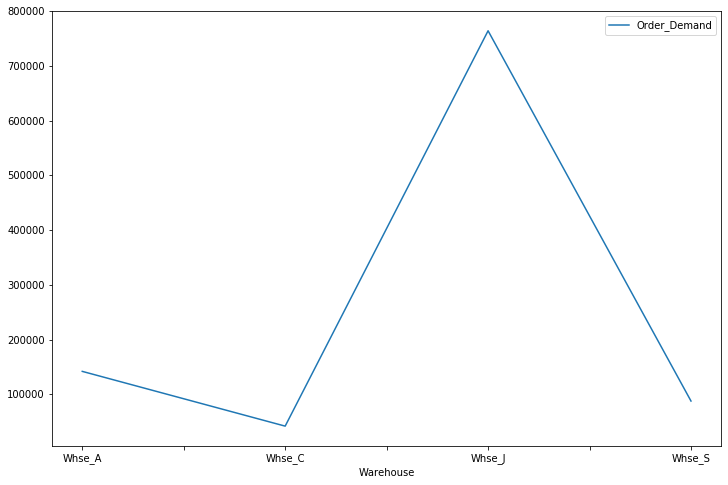

In [435]:
w_vs_od = df[['Warehouse', 'Order_Demand']].groupby('Warehouse').count()
w_vs_od
w_vs_od.plot(figsize = (12,8))

- Demand for orders from warehouse J is higher while order from warehouse is lowest.

### Product Category vs Order demand

,Order_Demand
Product_Category,
Category_001,97707
Category_002,77
Category_003,4187
Category_004,324
Category_005,101582
Category_006,35495
Category_007,82348
Category_008,1560
Category_009,19720


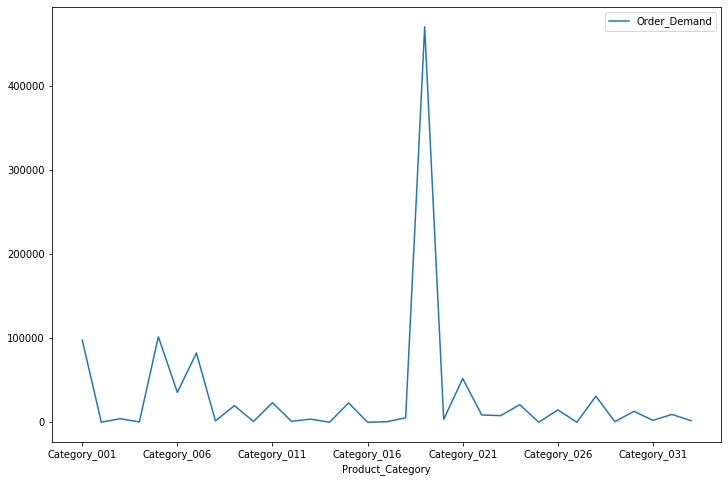

In [436]:
pc_vs_od = df[['Product_Category', 'Order_Demand']].groupby('Product_Category').count()
pc_vs_od
pc_vs_od.plot(figsize = (12,8))

- Clearly, order demand is higher for product category 19.

## Simple Time Series Plot

In [418]:
ts.set_index('Date', inplace = True)

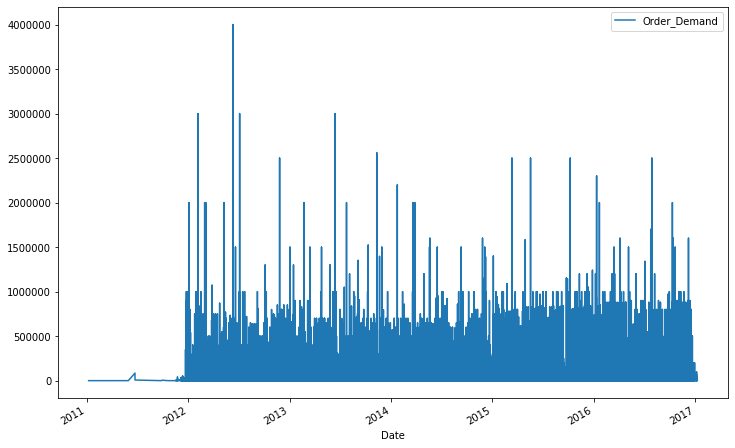

In [419]:
ts.plot(figsize = (12,8))

- From this plot we can find that the data from 2011 to 2012 is less uniform compared to the data from 2012 to 2017. Also, the data is only available for first 9 days of 2017. So, we will select our data inclusive of 2012 and 2016.
- Also, the plot is quiet dense. Let's try to visualize the data by resampling it on month start frequency.

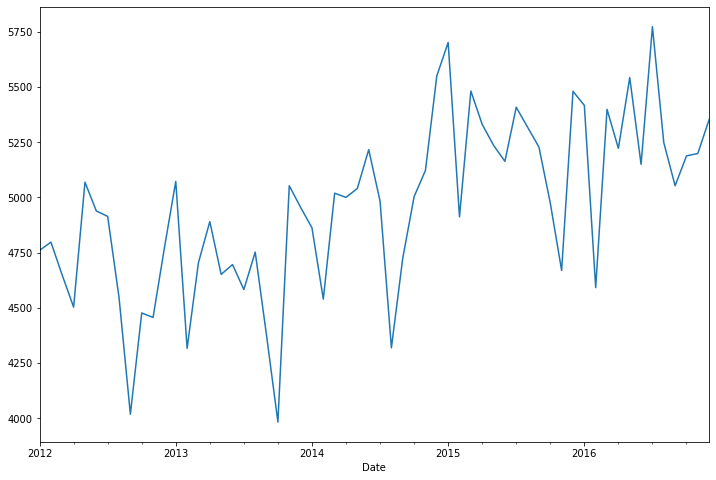

In [420]:
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')]
ts = df[['Date', 'Order_Demand']]
ts.set_index('Date', inplace = True)
ts = ts['Order_Demand'].resample('MS').mean()
ts.plot(figsize = (12,8))

- The graph shows that the order was high in middle of 2016 and was low in third quarter of 2013. 
- Except in 2016, the order is highest in first half of the year while it is lowest at the later half of the year.

# Decomposition

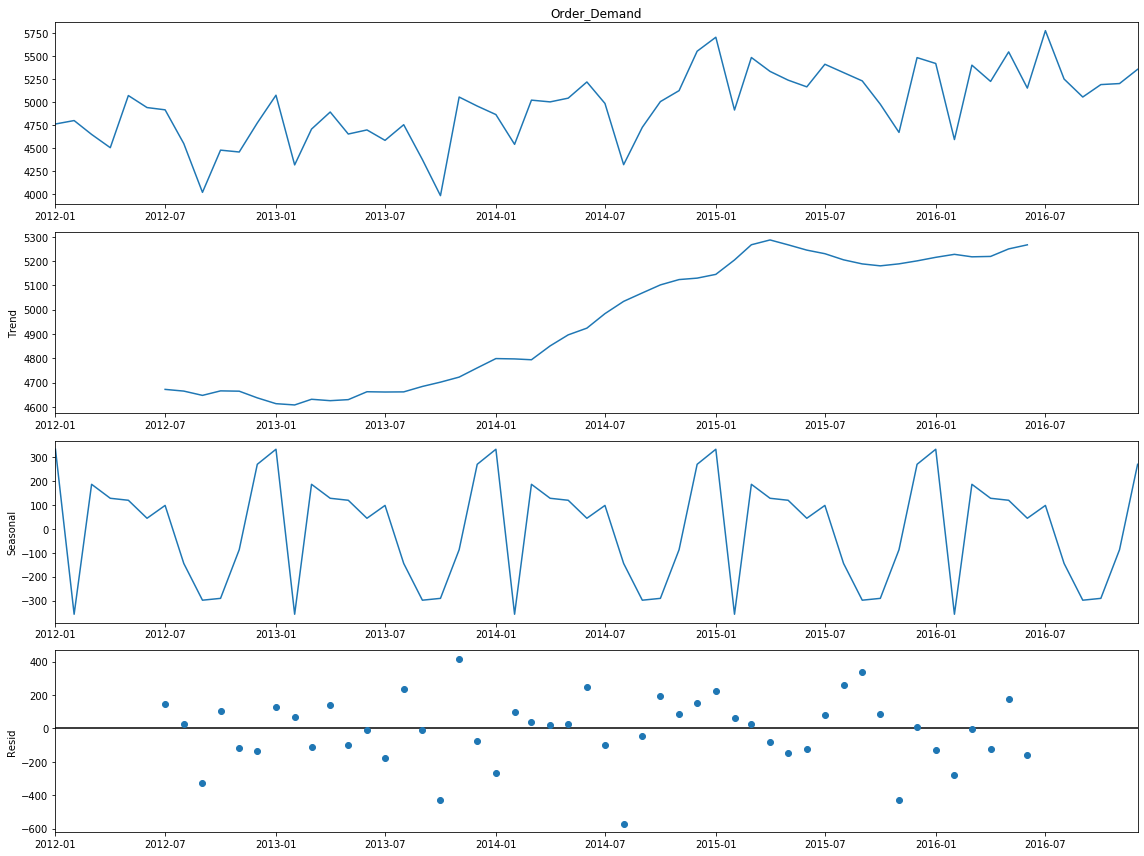

In [421]:
rcParams['figure.figsize'] = 16, 12
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

- From this plot, we can find that the trend(Order Demand) is increasing with increase in year.
- Also, there is a seasional pattern in the data.

# ARIMA

## Evaluate ARIMA Model
I will first split the data set into 70%(first 70%) train and 30% test. Then, train the ARIMA model to compute the error score for the prediction. After creating and evalute model, I will iterate through the value of p,d and q to find the best ARIMA parameters.

In [422]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X)*0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(disp = 0)
        pred = model_fit.forecast()[0]
        predictions.append(pred)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    print('order: ',arima_order,'error: ', error)
    return error      

## Evaluate order for ARIMA model.
For a grid of p,d and q all in range of 0 to 3, i will iterate the model and find the best parameters with low mean squared error.

In [423]:
def find_ARIMA_params (X, p_orders, d_orders, q_orders):
    best_score, best_conf = float('inf'), None
    for p in p_orders:
        for d in d_orders:
            for q in q_orders:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(X, order)
                    if mse < best_score:
                        best_score = mse
                        best_conf = order
                except:
                    continue
    print(f'Best Score: {best_score} best_order: {best_conf}')
    return best_score, best_conf            

In [424]:
p = d = q = range(0, 3)
warnings.filterwarnings("ignore")
best_score, best_order = find_ARIMA_params (ts.values,p,d,q)

order:  (0, 0, 0) error:  192236.75361337163
order:  (0, 0, 1) error:  164926.51609585018
order:  (0, 0, 2) error:  159611.96924760443
order:  (0, 1, 0) error:  184736.49320153217
order:  (0, 1, 1) error:  93797.04824609935
order:  (0, 1, 2) error:  99842.6653270011
order:  (0, 2, 0) error:  557155.4581299054
order:  (0, 2, 1) error:  192804.686444539
order:  (0, 2, 2) error:  145993.33964428803
order:  (1, 0, 0) error:  143894.0178084785
order:  (1, 0, 1) error:  115032.62575761131
order:  (1, 1, 0) error:  145872.7276677101
order:  (1, 1, 1) error:  98263.48376404775
order:  (1, 1, 2) error:  102376.95542334211
order:  (1, 2, 0) error:  337536.25111244153
order:  (2, 0, 0) error:  139249.0572666431
order:  (2, 0, 1) error:  123928.79415601323
order:  (2, 0, 2) error:  113794.51471068998
order:  (2, 1, 0) error:  129731.83770394411
order:  (2, 1, 1) error:  99702.65856552929
order:  (2, 2, 0) error:  260992.62843975885
Best Score: 93797.04824609935 best_order: (0, 1, 1)


- The best parameter for ARIMA model is (0,1,1). Now, let's see the result of the model.

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   59
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -423.413
Method:                       css-mle   S.D. of innovations            305.788
Date:                Mon, 12 Oct 2020   AIC                            852.826
Time:                        15:57:01   BIC                            859.058
Sample:                             1   HQIC                           855.259
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0267      2.279      6.154      0.000       9.559      18.494
ma.L1.D.y     -0.9999      0.070    -14.320      0.000      -1.137      -0.863
                                    Roots           

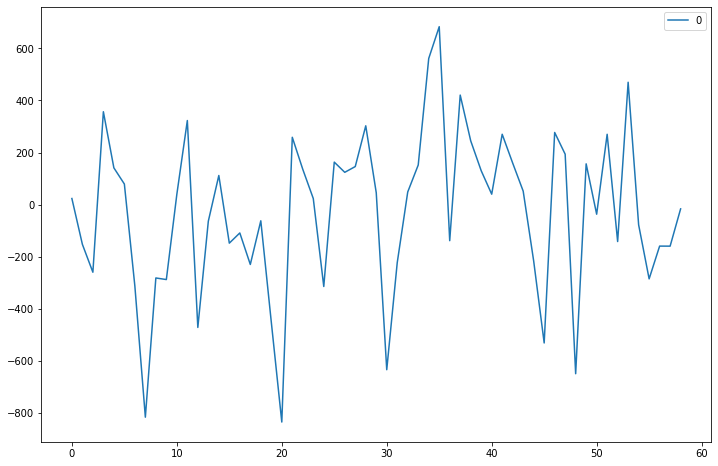

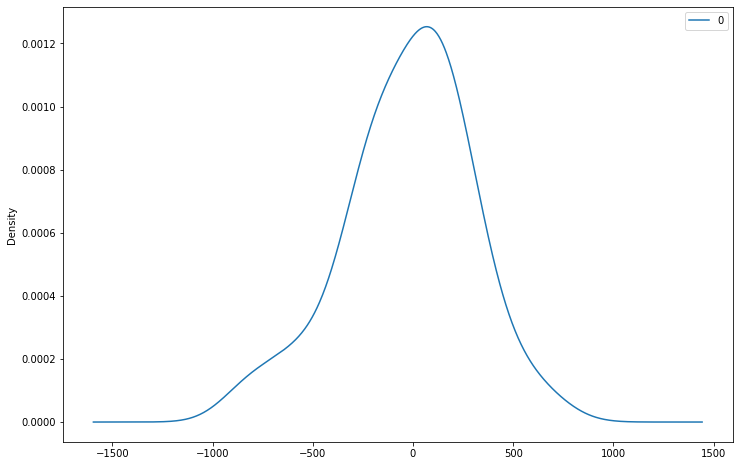

                0
count   59.000000
mean   -28.283529
std    315.735212
min   -835.213716
25%   -219.891538
50%     23.330163
75%    157.916168
max    683.274082


In [425]:
model = ARIMA(ts.values, order = (0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize = (12,8))
plt.show()
residuals.plot(figsize = (12,8), kind='kde')
plt.show()
print(residuals.describe())

- From the plot above, the residual plot shows that there is still some trend information not captured by the model also, we can find that the error is Gaussian not centered at 0.

# Rolling forecast ARIMA model
I will be using the order obtained(0,1,1) after iteration to make the prediction and later compare the plot of the expected value and predicted value.

In [426]:
train_size = int(len(ts)*0.70)
train, test = ts[0:train_size], ts[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order = (0,1,1))
    model_fit = model.fit(disp = 0)
    pred = model_fit.forecast()[0]
    predictions.append(pred)
    history.append(test[i])
    print(f'expected: {test[i]}, predicted: {pred}')

expected: 5408.57442358969, predicted: [5272.84292915]
expected: 5318.172115818663, predicted: [5317.31773212]
expected: 5228.155739673391, predicted: [5332.98076077]
expected: 4974.822097272983, predicted: [5326.65084263]
expected: 4669.399596192674, predicted: [5273.72921172]
expected: 5480.608467243511, predicted: [5146.25528722]
expected: 5416.990630382363, predicted: [5248.58415666]
expected: 4591.757036577806, predicted: [5291.1953579]
expected: 5398.906955213517, predicted: [5179.69823148]
expected: 5222.581882677528, predicted: [5246.50700489]
expected: 5542.872437357631, predicted: [5255.31520779]
expected: 5150.018942623949, predicted: [5310.99655298]
expected: 5773.218617403225, predicted: [5321.14695503]
expected: 5248.27313637253, predicted: [5358.14367912]
expected: 5053.258064516129, predicted: [5374.9550285]
expected: 5188.1141992464945, predicted: [5371.09182873]
expected: 5199.225151427748, predicted: [5371.0646562]
expected: 5353.679968076616, predicted: [5373.769604

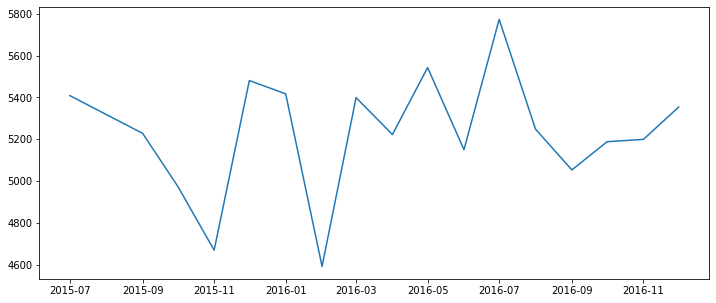

In [427]:
rcParams['figure.figsize'] = 12, 5
plt.plot(test)

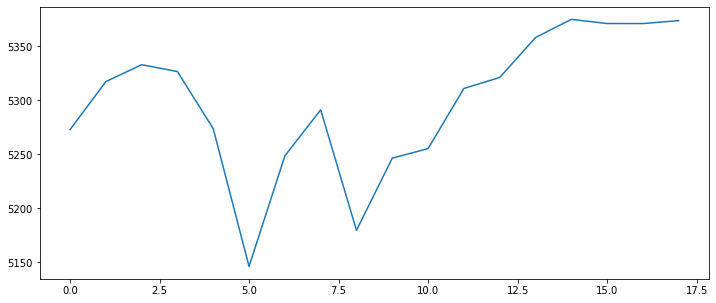

In [428]:
rcParams['figure.figsize'] = 12, 5
plt.plot(predictions)

- The predicted plot does not follow the test data. 
- Let's try with two ARIMA orders just greater than the best score. 
- i.e.,(1,1,1) and (2,1,1)

In [429]:
rain_size = int(len(ts)*0.70)
train, test = ts[0:train_size], ts[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order = (1,1,1))
    model_fit = model.fit(disp = 0)
    pred = model_fit.forecast()[0]
    predictions.append(pred)
    history.append(test[i])
    print(f'expected: {test[i]}, predicted: {pred}')

expected: 5408.57442358969, predicted: [5177.91469284]
expected: 5318.172115818663, predicted: [5279.43491977]
expected: 5228.155739673391, predicted: [5270.65393026]
expected: 4974.822097272983, predicted: [5252.50154963]
expected: 4669.399596192674, predicted: [5167.11735692]
expected: 5480.608467243511, predicted: [5027.12543281]
expected: 5416.990630382363, predicted: [5318.54245071]
expected: 4591.757036577806, predicted: [5325.9043241]
expected: 5398.906955213517, predicted: [5071.12115935]
expected: 5222.581882677528, predicted: [5297.35506022]
expected: 5542.872437357631, predicted: [5270.41340365]
expected: 5150.018942623949, predicted: [5365.37636638]
expected: 5773.218617403225, predicted: [5286.0752952]
expected: 5248.27313637253, predicted: [5442.69189428]
expected: 5053.258064516129, predicted: [5354.10844076]
expected: 5188.1141992464945, predicted: [5311.14945441]
expected: 5199.225151427748, predicted: [5335.17254072]
expected: 5353.679968076616, predicted: [5339.28380

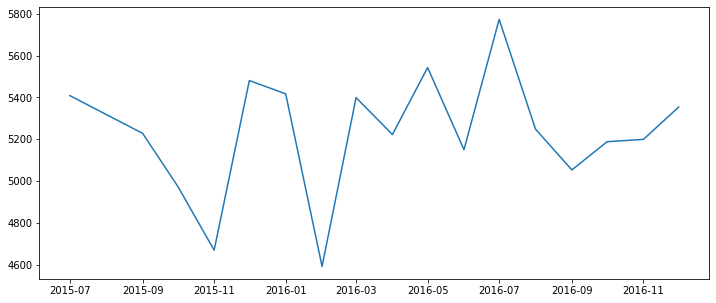

In [430]:
rcParams['figure.figsize'] = 12, 5
plt.plot(test)

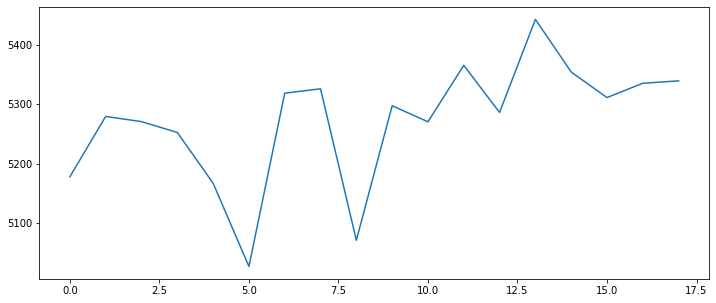

In [431]:
rcParams['figure.figsize'] = 12, 5
plt.plot(predictions)

expected: 5408.57442358969, predicted: [5177.91469284]
expected: 5318.172115818663, predicted: [5279.43491977]
expected: 5228.155739673391, predicted: [5270.65393026]
expected: 4974.822097272983, predicted: [5252.50154963]
expected: 4669.399596192674, predicted: [5167.11735692]
expected: 5480.608467243511, predicted: [5027.12543281]
expected: 5416.990630382363, predicted: [5318.54245071]
expected: 4591.757036577806, predicted: [5325.9043241]
expected: 5398.906955213517, predicted: [5071.12115935]
expected: 5222.581882677528, predicted: [5297.35506022]
expected: 5542.872437357631, predicted: [5270.41340365]
expected: 5150.018942623949, predicted: [5365.37636638]
expected: 5773.218617403225, predicted: [5286.0752952]
expected: 5248.27313637253, predicted: [5442.69189428]
expected: 5053.258064516129, predicted: [5354.10844076]
expected: 5188.1141992464945, predicted: [5311.14945441]
expected: 5199.225151427748, predicted: [5335.17254072]
expected: 5353.679968076616, predicted: [5339.28380

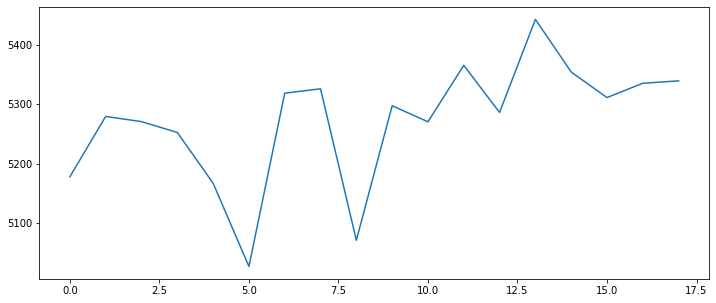

In [432]:
rain_size = int(len(ts)*0.70)
train, test = ts[0:train_size], ts[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order = (1,1,1))
    model_fit = model.fit(disp = 0)
    pred = model_fit.forecast()[0]
    predictions.append(pred)
    history.append(test[i])
    print(f'expected: {test[i]}, predicted: {pred}')
rcParams['figure.figsize'] = 12, 5
plt.plot(predictions)

- These two plots are similar and follows the test data but the order_demand values are lesser than that of test data.

## Facebook Prophet
Here, facebook prophet will be used to forecast the order demand for next 12 month. Prophet automatically add the yhat(forecast) value for the provided dataframe to. So, I will compare the result of test data with the yhat for each data point. Later, I will analyze the tred and yearly seasonality too.

In [433]:
df_prop = df[['Date', 'Order_Demand']]
df_prop.rename(columns = {'Date': 'ds', 'Order_Demand': 'y'}, inplace = True)
df_prop.set_index('ds', inplace = True)
df_prop = df_prop['y'].resample('MS').mean()
df_prop = df_prop.reset_index()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


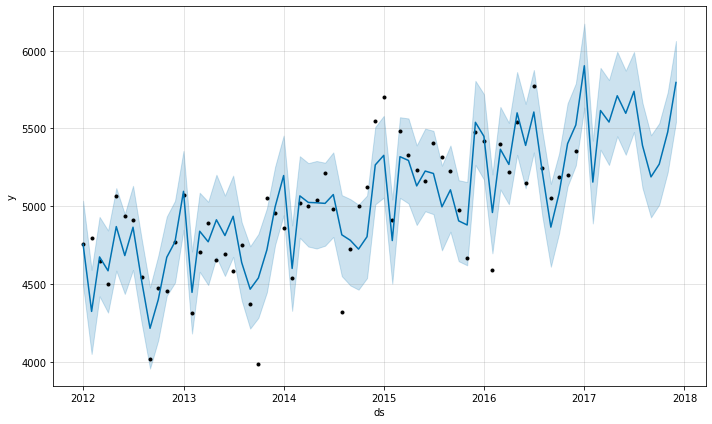

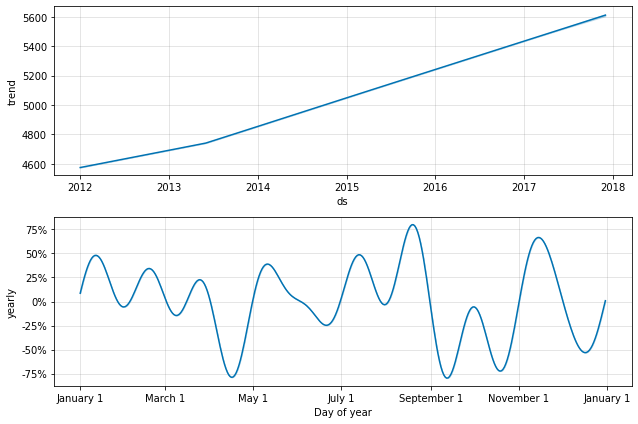

In [434]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_prop)
future = model.make_future_dataframe(periods=12, freq='MS')
fcst = model.predict(future)
fig = model.plot(fcst)
fig2 = model.plot_components(fcst)

- yhat(forecast) value for next 12 month is the part in the figure that does not have dots corresponding to it. The dots in the plot is the train data. 
- The trend shows that it is increasing after 2013, but when we compare it with the decomposition, the difference is that the trend increases till 2016 and then tries remain flat later.

**Comparing these two models, the result of the ARIMA model is better compared to that of Facebook Prophet in term of trend as well as prediction result.**